# Machine Learning Project

## Table of Contents
- [Import Data](#import-data)
- [Data Exploration](#data-exploration)
  - [Categorical Features](#categorical-features)
  - [Numerical Features](#numerical-features)
  - [Plots](#plots)
- [Pre-processing](#pre-processing)
  - [Missing Values](#missing-values)

<a id="import-data"></a>
## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
import os
os.getcwd()

'c:\\Users\\GoncaloUni\\Documents\\Nova IMS\\1º-Ano\\1º-Semestre\\MachineLearning\\Projeto\\machine_learning'

In [3]:
df = pd.read_csv('data/train.csv').set_index('carID')
df.head()

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75973 entries, 69512 to 15795
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           74452 non-null  object 
 1   model           74456 non-null  object 
 2   year            74482 non-null  float64
 3   price           75973 non-null  int64  
 4   transmission    74451 non-null  object 
 5   mileage         74510 non-null  float64
 6   fuelType        74462 non-null  object 
 7   tax             68069 non-null  float64
 8   mpg             68047 non-null  float64
 9   engineSize      74457 non-null  float64
 10  paintQuality%   74449 non-null  float64
 11  previousOwners  74423 non-null  float64
 12  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 8.1+ MB


<a id="data-exploration"></a>
## Data Exploration

<a id="categorical-features"></a>
### Categorical Features

#### Check Categorical Features Consistency

In [5]:
num_duplicated_ids = df.index.duplicated().sum()
print(f'Number of duplicated carIDs: {num_duplicated_ids}')

Number of duplicated carIDs: 0


<a id="numerical-features"></a>
### Numerical Features

<a id="plots"></a>
### Plots

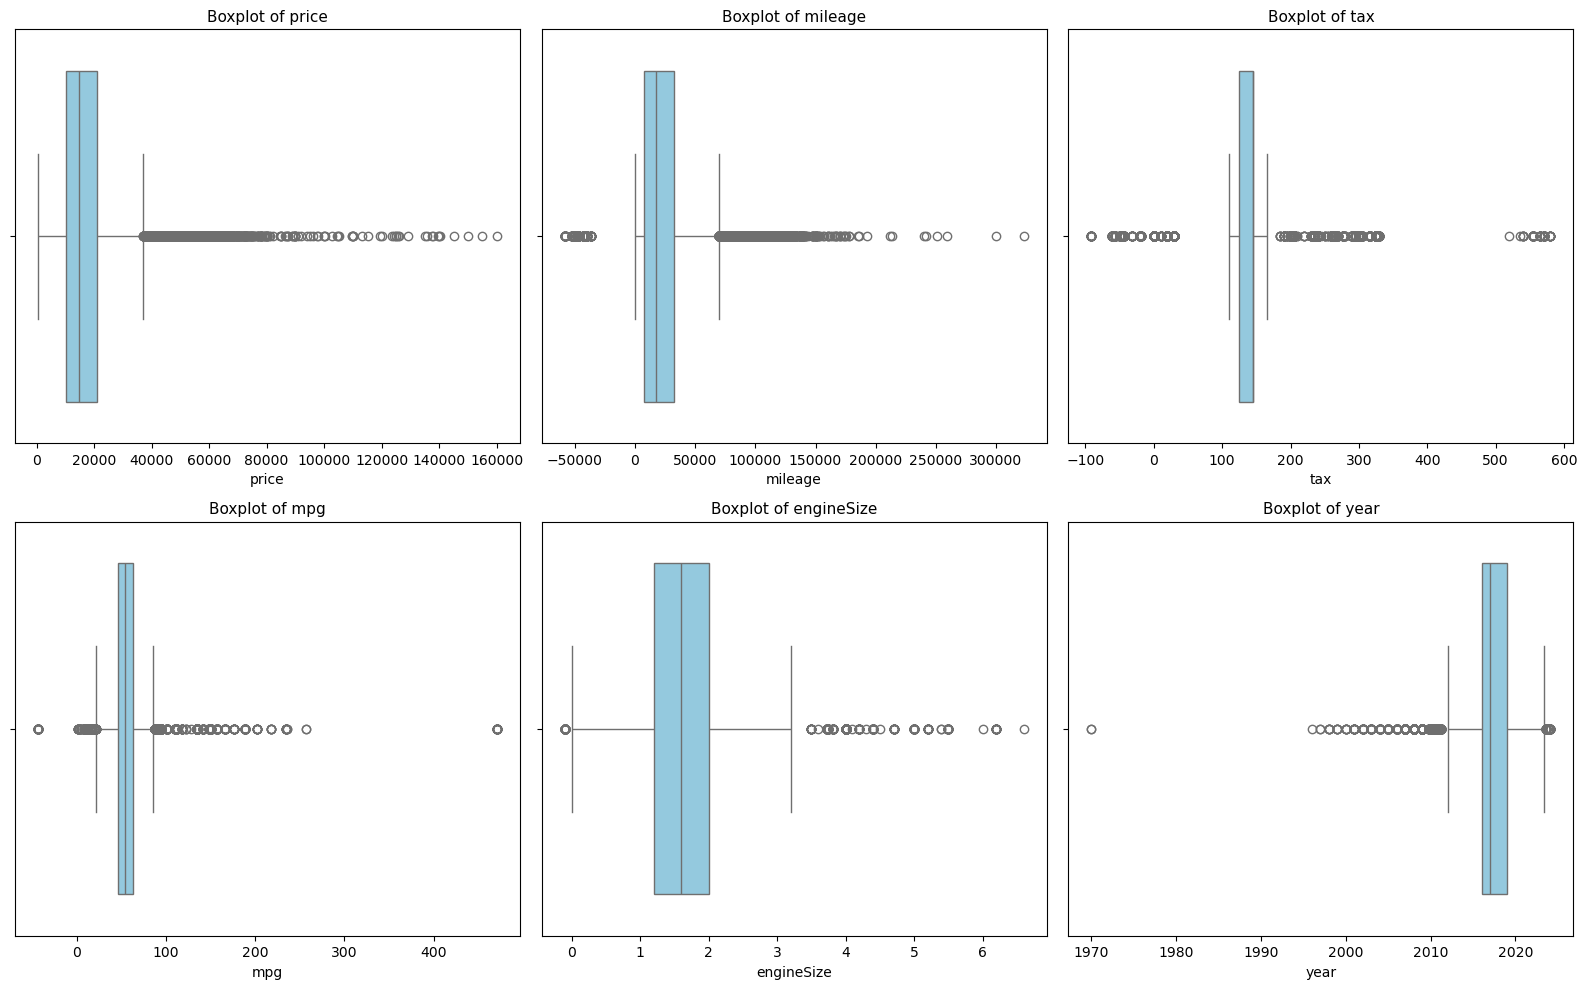

In [6]:
num_cols = ['price', 'mileage', 'tax', 'mpg', 'engineSize', 'year']

plt.figure(figsize=(16, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x=col, color="skyblue")
    plt.title(f"Boxplot of {col}", fontsize=11)
plt.tight_layout()
plt.show()

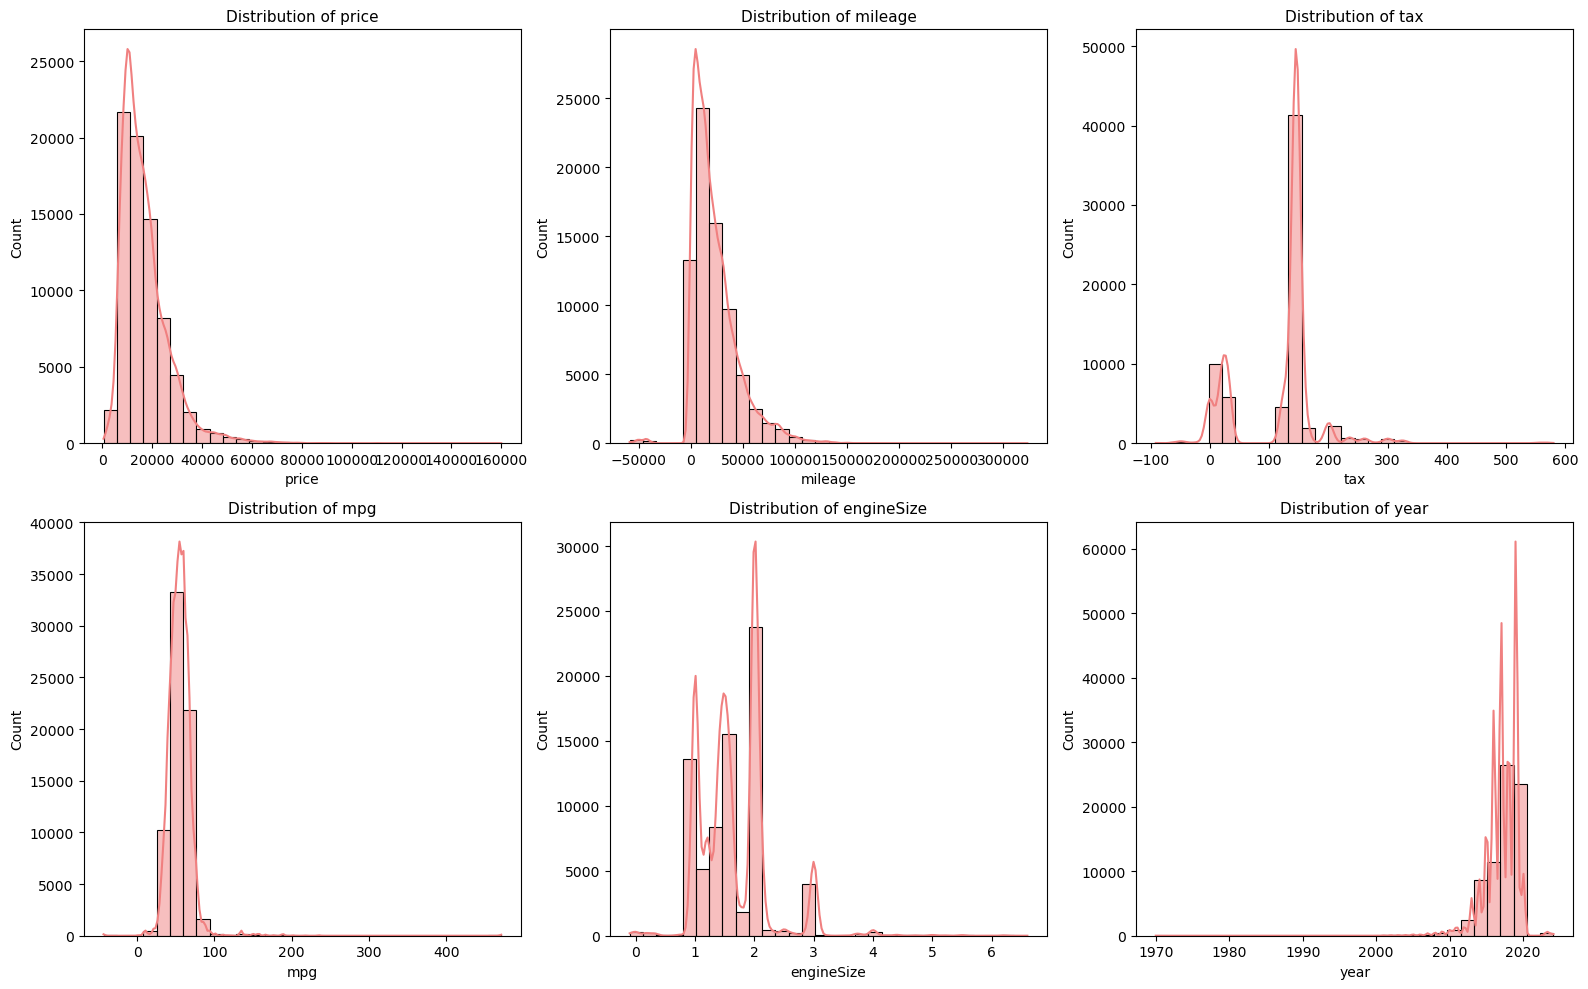

In [7]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col, bins=30, kde=True, color="lightcoral")
    plt.title(f"Distribution of {col}", fontsize=11)
plt.tight_layout()
plt.show()

<a id="pre-processing"></a>
## Pre-processing

In [8]:
X = df.drop(columns=["price"])   
y = df["price"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Training set size: (60778, 12)
Validation set size: (15195, 12)


In [9]:
X_train_clean = X_train.copy()
X_val_clean = X_val.copy()

<a id="missing-values"></a>
### Missing Values

In [10]:
missing_counts = X_train_clean.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

missing_summary = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_percent.round(2)
}).sort_values(by="Missing %", ascending=False)

missing_summary[missing_summary["Missing Count"] > 0]

,Missing Count,Missing %
tax,6361,8.37
mpg,6360,8.37
hasDamage,1237,1.63
transmission,1231,1.62
engineSize,1227,1.62
paintQuality%,1217,1.60
Brand,1219,1.60
previousOwners,1206,1.59
year,1200,1.58
model,1196,1.57


In [11]:
num_general = ["tax", "previousOwners", "paintQuality%", "engineSize"]

median_imputer = SimpleImputer(strategy="median")
X_train_clean[num_general] = median_imputer.fit_transform(X_train_clean[num_general])
X_val_clean[num_general] = median_imputer.transform(X_val_clean[num_general])

In [12]:
if "mpg" in X_train_clean.columns and "fuelType" in X_train_clean.columns:
    mpg_group_medians = X_train_clean.groupby("fuelType")["mpg"].median()

    def impute_mpg(row):
        if pd.isnull(row["mpg"]):
            return mpg_group_medians.get(row["fuelType"], X_train_clean["mpg"].median())
        return row["mpg"]

    X_train_clean["mpg"] = X_train_clean.apply(impute_mpg, axis=1)
    X_val_clean["mpg"] = X_val_clean.apply(impute_mpg, axis=1)

In [13]:
cat_general = ["Brand", "model", "transmission", "fuelType"]

mode_imputer = SimpleImputer(strategy="most_frequent")
X_train_clean[cat_general] = mode_imputer.fit_transform(X_train_clean[cat_general])
X_val_clean[cat_general] = mode_imputer.transform(X_val_clean[cat_general])

In [14]:
if "hasDamage" in X_train_clean.columns:
    X_train_clean["hasDamage"] = X_train_clean["hasDamage"].fillna("Unknown")
    X_val_clean["hasDamage"] = X_val_clean["hasDamage"].fillna("Unknown")

In [15]:
missing_summary_train = X_train_clean.isnull().sum()
missing_summary_val = X_val_clean.isnull().sum()

print("Remaining missing values (train):", missing_summary_train.sum())
print("Remaining missing values (validation):", missing_summary_val.sum())

Remaining missing values (train): 2359
Remaining missing values (validation): 596


In [16]:
remaining_missing = X_train_clean.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print("Columns with remaining NaN values:")
display(remaining_missing)

Columns with remaining NaN values:


year       1200
mileage    1158
mpg           1
dtype: int64

In [17]:
for col in ["year", "mileage", "mpg"]:
    if col in X_train_clean.columns:
        median_value = X_train_clean[col].median()
        X_train_clean[col].fillna(median_value, inplace=True)
        X_val_clean[col].fillna(median_value, inplace=True)

remaining_missing = X_train_clean.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print("Columns with remaining NaN values after final cleaning:")
display(remaining_missing)

Columns with remaining NaN values after final cleaning:


C:\Users\GoncaloUni\AppData\Local\Temp\ipykernel_12588\3648844205.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_clean[col].fillna(median_value, inplace=True)
C:\Users\GoncaloUni\AppData\Local\Temp\ipykernel_12588\3648844205.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

Series([], dtype: int64)

In [18]:
remaining_missing = X_train_clean.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print("Columns with remaining NaN values:")
display(remaining_missing)

Columns with remaining NaN values:


Series([], dtype: int64)

Outliers

In [19]:
num_cols = X_train_clean.select_dtypes(include=["int64", "float64"]).columns

outlier_summary = []

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = X_train_clean[(X_train_clean[col] < lower_bound) | (X_train_clean[col] > upper_bound)]
    
    outlier_summary.append({
        "Feature": col,
        "Lower Bound": round(lower_bound, 2),
        "Upper Bound": round(upper_bound, 2),
        "Outlier Count": len(outliers),
        "Outlier %": round(len(outliers) / len(df) * 100, 2)
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values(by="Outlier %", ascending=False)
outlier_df

,Feature,Lower Bound,Upper Bound,Outlier Count,Outlier %
2,tax,95.00,175.00,16233,21.37
1,mileage,-30083.12,69933.88,2877,3.79
0,year,2011.50,2023.50,1423,1.87
3,mpg,21.55,87.55,975,1.28
6,previousOwners,-2.00,6.00,586,0.77
4,engineSize,-0.00,3.20,581,0.76
5,paintQuality%,-5.50,134.50,0,0.00


### Numeric Features

- carID
- year
- price
- mileage
- tax
- mpg
- engineSize
- paintQuality
- previousOwners
- hasDamage


In [20]:
#Check if there are negative features that should not be negative
numeric_features = X_train_clean.select_dtypes(include=['int64', 'float64']).columns
negative_values = {}
for col in numeric_features:
    negative_count = (X_train_clean[col] < 0).sum()
    if negative_count > 0:
        negative_values[col] = negative_count   

for v in negative_values:
    print(f"Feature '{v}' has {negative_values[v]} negative values.")

Feature 'mileage' has 305 negative values.
Feature 'tax' has 294 negative values.
Feature 'mpg' has 28 negative values.
Feature 'engineSize' has 73 negative values.
Feature 'previousOwners' has 289 negative values.


### Strategy:

- Change negative values to `NaN`
- Remove extreme outliers
- Impute using the appropriate method (median, mode, or group-based)
- Convert the column back to integer type if applicable

Note: Still have to choose what method to use to change the missing values in the feature "hasDamage" before I can switch from float to int

In [21]:
cols_to_fix = list(negative_values.keys())

for feature in cols_to_fix:
    X_train_clean.loc[X_train_clean[feature] < 0, feature] = np.nan
    X_val_clean.loc[X_val_clean[feature] < 0, feature] = np.nan


In [22]:
for col in X_train_clean.select_dtypes(include=['int64', 'float64']).columns:
    q1 = X_train_clean[col].quantile(0.25)
    q3 = X_train_clean[col].quantile(0.75)
    iqr = q3 - q1
    lower_lim = q1 - (1.5 * iqr)
    upper_lim = q3 + (1.5 * iqr)
    X_train_clean[col] = X_train_clean[col].mask((X_train_clean[col] < lower_lim) | (X_train_clean[col] > upper_lim), np.nan)
    X_val_clean[col] = X_val_clean[col].mask((X_val_clean[col] < lower_lim) | (X_val_clean[col] > upper_lim), np.nan)


In [23]:
for feature in cols_to_fix:
    median_value = X_train_clean[feature].median()
    X_train_clean[feature].fillna(median_value, inplace=True)
    X_val_clean[feature].fillna(median_value, inplace=True)


C:\Users\GoncaloUni\AppData\Local\Temp\ipykernel_12588\1560256754.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_clean[feature].fillna(median_value, inplace=True)
C:\Users\GoncaloUni\AppData\Local\Temp\ipykernel_12588\1560256754.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

In [24]:
int_cols = ['year', 'previousOwners']

median_year = X_train_clean['year'].median()
X_train_clean['year'].fillna(median_year, inplace=True)
X_val_clean['year'].fillna(median_year, inplace=True)

for feature in int_cols:
    X_train_clean[feature] = X_train_clean[feature].astype(int)
    X_val_clean[feature] = X_val_clean[feature].astype(int)

C:\Users\GoncaloUni\AppData\Local\Temp\ipykernel_12588\150842670.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_clean['year'].fillna(median_year, inplace=True)
C:\Users\GoncaloUni\AppData\Local\Temp\ipykernel_12588\150842670.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [25]:
(X_train_clean["year"] < 1950).sum() and (X_train_clean["year"] > 2025).sum()

np.int64(0)

In [26]:
X_train_clean.head()


,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
17712,Ford,Fiesta,2018,Manual,25943.0,Petrol,145.0,65.7,1.0,34.0,1,0.0
60272,Opel,Mokka X,2018,unknow,28993.0,Petrol,145.0,47.1,1.4,60.0,4,0.0
54409,Toyota,Yaris,2014,automatic,66158.0,Hybrid,145.0,76.3,1.5,97.0,1,0.0
60966,Opel,Corsa,2017,Manual,22759.0,Petrol,145.0,55.4,1.4,69.0,2,0.0
2891,Audi,Q3,2018,Semi-Auto,4847.0,Petrol,145.0,40.4,2.0,51.0,4,0.0


In [27]:
X_val_clean.head()

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
44722,Mercedes,GLC Class,2018,Automatic,9500.0,Diesel,150.0,56.5,2.1,77.0,0,Unknown
35963,Mercedes,C Class,2017,Automatic,50369.0,Diesel,145.0,65.7,2.1,80.0,4,0.0
50618,Skoda,Citigo,2017,manual,7489.0,Petrol,150.0,64.2,1.0,84.0,4,0.0
69344,VW,Touareg,2019,Automatic,7000.0,Diesel,145.0,34.0,3.0,62.0,0,0.0
26815,Ford,Focus,2019,Manual,10812.0,DIESEL,145.0,60.1,1.5,99.0,2,0.0


Final check for nan values

In [28]:
X_train_clean.isnull().sum()

Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
hasDamage         0
dtype: int64

Check for other strange values

In [29]:
print(f"Number of percentages above 100: {(X_train_clean["paintQuality%"] > 100).sum()}")

Number of percentages above 100: 290


In [30]:
X_train_clean.loc[(X_train_clean['paintQuality%'] > 100), 'paintQuality%'] = np.nan
X_val_clean.loc[(X_val_clean['paintQuality%'] > 100), 'paintQuality%'] = np.nan

median_paint = X_train_clean['paintQuality%'].median()
X_train_clean['paintQuality%'].fillna(median_paint, inplace=True)
X_val_clean['paintQuality%'].fillna(median_paint, inplace=True)



C:\Users\GoncaloUni\AppData\Local\Temp\ipykernel_12588\567158984.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_clean['paintQuality%'].fillna(median_paint, inplace=True)
C:\Users\GoncaloUni\AppData\Local\Temp\ipykernel_12588\567158984.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be